# Calculating Discrete CDF

The goal of this notebook is to develop an alternate method of normalizing data sampled from an unknown distribution over $[0, \infty]$ to a range of $[0, 1]$. 

One method is to divide each element in the sample by its maximum. This is suceptible to outiers, and could fail to capture the nuance of the distribution of data.

An alternate solution might be to use the entire distribution of observed data, and not just its maxiumum, to make a normalization.

In [1]:
import numpy as np
import scipy as scp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(seed=125)

## Generate Data

Lots of biological experiments produce data that has an extreme bias towards 0. This notebook represents that with a gamma distribution, with added gaussian noise to simulate experimental error.

All data points less than zero were changed to be zero, to reflect a real-world scenario.

First, we'll display a histogram of this data.

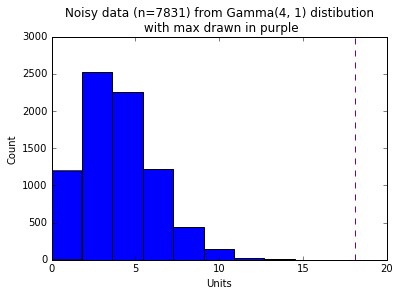

In [2]:
n = 7831
k, theta = 4, 1

noise = np.random.normal(size=n)
data = np.random.gamma(shape=k, scale=theta, size=n) + noise 
data = np.array([d if d > 0 else 0 for d in data])

plt.hist(data)
plt.title("Noisy data (n={}) from Gamma({}, {}) distibution\n with max drawn in purple".format(n, k, theta))
plt.axvline(max(data), color='purple', ls="dashed")
plt.xlabel("Units")
plt.ylabel("Count")

## Scaling Problem

I think the problem with scaling by the maximum becomes apparent when the value of normalization is compared to the distance of two points.

Consider a data from the original $Gamma(4, 1)$ distribution around 2 and 4. Also consider two samples around 8 and 10.

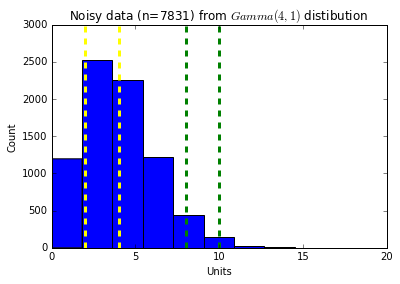

In [3]:
plt.hist(data)
plt.title("Noisy data (n={}) from $Gamma({}, {})$ distibution".format(n, k, theta))
plt.xlabel("Units")
plt.ylabel("Count")
plt.axvline(2, linewidth=3, color='yellow', ls="dashed")
plt.axvline(4, linewidth=3, color='yellow', ls="dashed")
plt.axvline(8, linewidth=3, color='green', ls="dashed")
plt.axvline(10, linewidth=3, color='green', ls="dashed")

I think the problem here is apparent - the proportion of elements between $[2,4]$ and $[8,10]$ is clearly not captured by a normalization by the maximum, since this effort just scales the data linearly.

Since we're assuming an unknown distribution, we can't assume any relation between two independent sections of the sample. Even if it looks like this discrepancy is captured for a given distribution, that might not hold for another one. 

## Calculating Discrete CDF

1. Sort data
2. Calculate Proportionals
3. Plot Data vs. Proportionals

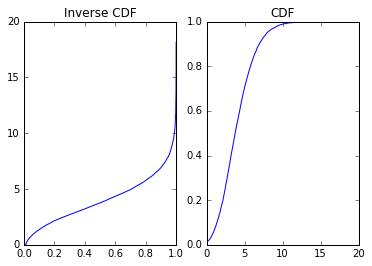

In [4]:
data = np.sort(data)
proportionals = np.arange(len(data)) / (len(data) - 1)

f, ax = plt.subplots(1, 2)

ax[0].plot(proportionals, data)
ax[0].set_title('Inverse CDF')

ax[1].plot(data, proportionals)
ax[1].set_title('CDF')

## Apply CDF to Normalize 

There is probably a better algorithm to find the appropriate p-value, but this one runs in $\mathcal{O}(n)$ and takes no extra memory besides storing `data` and `proportionals`.

As an example, a random number is generated from the same distribution as the CDF, and the probability is calculated.

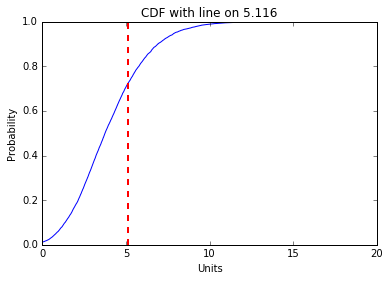

In [5]:
sampled = np.random.gamma(5,1) + np.random.normal()

plt.plot(data, proportionals)
plt.axvline(sampled, linewidth=2, color='red', ls="dashed")
plt.title("CDF with line on {}".format(round(sampled, 3)))
plt.xlabel("Units")
plt.ylabel("Probability")

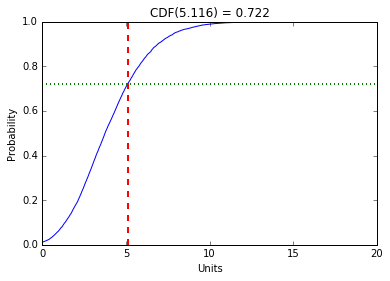

In [6]:
def normalize(sa, da, pr):
    for d, p in zip(da, pr):
        if d >= sa:
            return p
        
found = normalize(sampled, data, proportionals)

plt.plot(data, proportionals)
plt.axvline(sampled, linewidth=2, color='red', ls="dashed")
plt.axhline(found, linewidth=2, color='green', ls="dotted")
plt.title("CDF({}) = {}".format(round(sampled, 3), round(found,3)))
plt.xlabel("Units")
plt.ylabel("Probability")

## Normalization Over All Data 

The process of normalizing a data set with its own CDF is actually much more straightforwards than the examples given - it's identical to mapping each observation to its proportional. Practically, this is as easy as sorting the list.

### Inefficient Calculation of CDF
Using the following python code

```python
normalized = [normalize(d, data, proportionals) for d in data]
```

to calculate the normalized values is $\mathcal{O}(n^2)$, which is much worse than just referencing the pre-calculated proportionals,

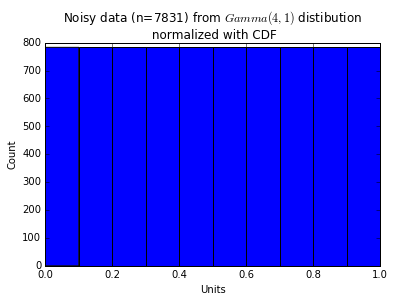

In [7]:
normalized = proportionals
plt.hist(normalized)
plt.title("Noisy data (n={}) from $Gamma({}, {})$ distibution\n normalized with CDF".format(n, k, theta))
plt.xlabel("Units")
plt.ylabel("Count")

## Practical Application

There are many applications where data isn't as simple as numbers and an array can't be directly sorted. Here's an example of using some "satellite" data (implemented with a python enumeration) and functional programming to help.

This approach generates the permutation corresponding to the sorting of a list, given the transformation `sort_key` over a complex element of `example_data`. In this example, that complex element is pair of a dictionary and number. The corresponding transformation extracts the value for `data` in the dictionary to use as the sort key, and a mapping is built. The mapping is then turned into a dictionary to be used to produce the output.

Finally, the mapping is applied to the array in place. Disclaimer: This code is much less elegant than the rest because actual use cases will be very specific and a lot of this has to do with the structure of the data.

In [9]:
example_data = [({'seq': 'TTAGCA', 'type': 'nucleotides', 'data': 21.933}, 0.650), # 1.000
        ({'seq': 'CTTAAA', 'type': 'nucleotides', 'data':  6.156}, 0.104), # 0.500
        ({'seq': 'GGTTGG', 'type': 'nucleotides', 'data': 10.537}, 0.041), # 0.750
        ({'seq': 'ACACAT', 'type': 'nucleotides', 'data':  1.058}, 0.963), # 0.000
        ({'seq': 'CTGCTG', 'type': 'nucleotides', 'data':  1.058}, 0.147), # 0.125
        ({'seq': 'GCGCCG', 'type': 'nucleotides', 'data':  6.631}, 0.349), # 0.625
        ({'seq': 'CACTCG', 'type': 'nucleotides', 'data': 19.221}, 0.360), # 0.875
        ({'seq': 'GATTTG', 'type': 'nucleotides', 'data':  1.599}, 0.775), # 0.250
        ({'seq': 'GAGGGC', 'type': 'nucleotides', 'data':  1.778}, 0.391)] # 0.375
proportionals = np.arange(len(example_data)) / (len(example_data) - 1)
sort_key = lambda row: row[0]['data']
#print("f({}) => {}".format(data[0], sort_key(data[0])))

# build mapping with enumeration. uses additional lambda in order to avoid considering the 
# logic with the enumeration when writing the transformation function f
def wrap_sort_key(fn):
    def unwrap_apply(i_el):
        i, el = i_el
        return fn(el)
    return unwrap_apply

# build the mapping as a useful dictionary
mapping = [i for i, el in sorted(enumerate(example_data), key=wrap_sort_key(sort_key))]
mapping = {k: i for i, k in enumerate(mapping)}

# crude output of new data
data = [(example_data[i], mapping[i], proportionals[mapping[i]]) for i in range(len(example_data))]
pd.DataFrame(example_data, columns=["example data", "sort mapping", "proportional"])

AssertionError: 3 columns passed, passed data had 2 columns

## Conclusions

In an experiment, if multiple readings are taken for the same biological sample, it is interesting to perform a heirarachical cluster on the results. It might be advantageous to the clustering method if each of the elements of a sample's observation vector are sampled from a uniform distribution. This might remove the bias from one particular observation.